In [189]:
from pathlib import Path
import pandas as pd
import numpy as np

# Dynamically locate project root
PROJECT_ROOT = Path().resolve()
while not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data" / "processed"
MODELS_PATH = PROJECT_ROOT / "models"
VIZ_PATH = PROJECT_ROOT / "visualizations"

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)


Project root: C:\Users\kvina\Documents\partnr\ecommerce-churn-prediction
Data path: C:\Users\kvina\Documents\partnr\ecommerce-churn-prediction\data\processed


In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
from sklearn.model_selection import train_test_split

print("=" * 70)
print("FINAL MODEL EVALUATION & VALIDATION")
print("=" * 70)

FINAL MODEL EVALUATION & VALIDATION


In [191]:
BASE_DIR = Path.cwd()

possible_data_dirs = [
    BASE_DIR / "data/processed",
    BASE_DIR / "../data/processed",
    BASE_DIR / "../../data/processed"
]

possible_model_dirs = [
    BASE_DIR / "models",
    BASE_DIR / "../models",
    BASE_DIR / "../../models"
]

data_dir = next((d for d in possible_data_dirs if d.exists()), None)
model_dir = next((d for d in possible_model_dirs if d.exists()), None)

if data_dir is None:
    raise FileNotFoundError("❌ data/processed directory not found")

if model_dir is None:
    raise FileNotFoundError("❌ models directory not found")

print(f"✓ Data directory: {data_dir}")
print(f"✓ Model directory: {model_dir}")

✓ Data directory: C:\Users\kvina\Documents\partnr\ecommerce-churn-prediction\data\processed
✓ Model directory: C:\Users\kvina\Documents\partnr\ecommerce-churn-prediction\models


In [192]:
df = pd.read_csv(data_dir / "customer_features.csv")
print(f"✓ Dataset loaded: {df.shape}")

y = df["churn"]

✓ Dataset loaded: (3223, 32)


In [193]:
feature_columns = joblib.load(model_dir / "feature_columns.pkl")
print(f"✓ Loaded {len(feature_columns)} trained feature columns")

✓ Loaded 51 trained feature columns


In [194]:
drop_cols = [
    "customerid",
    "first_purchase",
    "last_purchase",
    "recency_days",
    "days_since_last_purchase"
]

drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols + ["churn"], errors="ignore")

# Recreate missing engineered features safely
for col in feature_columns:
    if col not in X.columns:
        if col.endswith("_log"):
            base_col = col.replace("_log", "")
            if base_col in X.columns:
                X[col] = np.log1p(X[base_col])
            else:
                X[col] = 0
        else:
            X[col] = 0

# Enforce exact column order
X = X[feature_columns]

print(f"✓ Feature matrix aligned: {X.shape}")

✓ Feature matrix aligned: (3223, 51)


In [195]:
model = joblib.load(model_dir / "best_model_optimized.pkl")
scaler = joblib.load(model_dir / "scaler.pkl")
imputer = joblib.load(model_dir / "imputer.pkl")
threshold = joblib.load(model_dir / "optimal_threshold.pkl")["threshold"]

print("✓ Model, scaler, imputer, threshold loaded")

✓ Model, scaler, imputer, threshold loaded


In [196]:
X_imputed = imputer.transform(X)
X_scaled = scaler.transform(X_imputed)

In [197]:
y_prob = model.predict_proba(X_scaled)[:, 1]
y_pred_default = model.predict(X_scaled)
y_pred_optimized = (y_prob >= threshold).astype(int)

In [198]:
roc_auc = roc_auc_score(y, y_prob)
f1_default = f1_score(y, y_pred_default)
f1_optimized = f1_score(y, y_pred_optimized)

print("\n" + "="*70)
print("FINAL EVALUATION RESULTS")
print("="*70)

print(f"ROC-AUC           : {roc_auc:.4f}")
print(f"F1 (default 0.5)  : {f1_default:.4f}")
print(f"F1 (optimized)   : {f1_optimized:.4f}")
print(f"Optimal Threshold: {threshold:.3f}")

print("\nClassification Report (Optimized Threshold):")
print(classification_report(y, y_pred_optimized))

print("\nConfusion Matrix (Optimized Threshold):")
print(confusion_matrix(y, y_pred_optimized))

print("="*70)
print("FILE 5 COMPLETED SUCCESSFULLY")
print("="*70)


FINAL EVALUATION RESULTS
ROC-AUC           : 0.7488
F1 (default 0.5)  : 0.6256
F1 (optimized)   : 0.6293
Optimal Threshold: 0.521

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      2049
           1       0.53      0.77      0.63      1174

    accuracy                           0.67      3223
   macro avg       0.68      0.69      0.67      3223
weighted avg       0.72      0.67      0.68      3223


Confusion Matrix (Optimized Threshold):
[[1254  795]
 [ 270  904]]
FILE 5 COMPLETED SUCCESSFULLY


In [199]:
import numpy as np
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")


In [200]:
df = pd.read_csv(DATA_PATH / "customer_features.csv")

drop_cols = ["customerid", "churn"]
X = df.drop(columns=drop_cols)
y = df["churn"]


In [201]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)


In [202]:
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_val   = scaler.transform(imputer.transform(X_val))


In [204]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1": f1_score(y, y_pred),
        "roc_auc": roc_auc_score(y, y_prob)
    }


In [205]:
start = time.time()

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
log_reg.fit(X_train, y_train)

log_metrics = evaluate(log_reg, X_val, y_val)
log_time = time.time() - start


In [206]:
start = time.time()

dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)
dt.fit(X_train, y_train)

dt_metrics = evaluate(dt, X_val, y_val)
dt_time = time.time() - start


In [207]:
start = time.time()

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

rf_metrics = evaluate(rf, X_val, y_val)
rf_time = time.time() - start


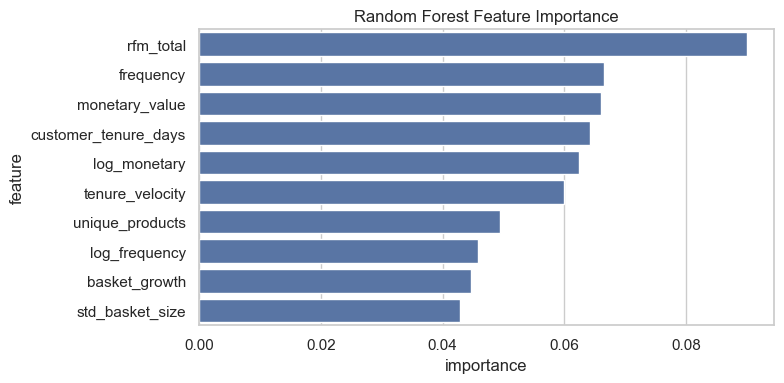

In [208]:
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(data=rf_importance, x="importance", y="feature")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("../visualizations/rf_feature_importance.png")
plt.show()


In [209]:
start = time.time()

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb.fit(X_train, y_train)

gb_metrics = evaluate(gb, X_val, y_val)
gb_time = time.time() - start


In [210]:
start = time.time()

nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42
)
nn.fit(X_train, y_train)

nn_metrics = evaluate(nn, X_val, y_val)
nn_time = time.time() - start


In [211]:
model_comparison = pd.DataFrame([
    ["Logistic Regression", *log_metrics.values(), log_time],
    ["Decision Tree", *dt_metrics.values(), dt_time],
    ["Random Forest", *rf_metrics.values(), rf_time],
    ["Gradient Boosting", *gb_metrics.values(), gb_time],
    ["Neural Network", *nn_metrics.values(), nn_time]
], columns=[
    "Model", "Accuracy", "Precision", "Recall",
    "F1-Score", "ROC-AUC", "Training_Time"
])

model_comparison


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training_Time
0,Logistic Regression,0.652534,0.516000,0.732955,0.605634,0.731435,0.060660
1,Decision Tree,0.612203,0.479501,0.764205,0.589266,0.684964,0.052904
2,Random Forest,0.671148,0.537281,0.696023,0.606436,0.734848,0.688772
3,Gradient Boosting,0.680455,0.565749,0.525568,0.544919,0.728825,2.662723
4,Neural Network,0.621510,0.482143,0.536932,0.508065,0.654148,5.758954


In [213]:
model_comparison.to_csv("../models/model_comparison.csv", index=False)

joblib.dump(log_reg, "../models/logistic_regression.pkl")
joblib.dump(dt, "../models/decision_tree.pkl")
joblib.dump(rf, "../models/random_forest.pkl")
joblib.dump(gb, "../models/gradient_boosting.pkl")
joblib.dump(nn, "../models/neural_network.pkl")
joblib.dump(imputer, "../models/imputer.pkl")
joblib.dump(scaler, "../models/scaler.pkl")


['../models/scaler.pkl']

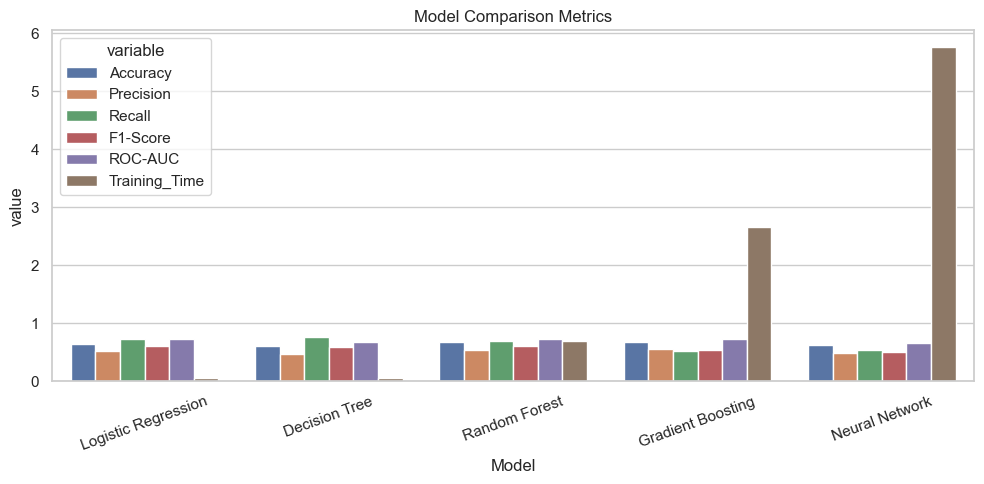

In [214]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=model_comparison.melt(id_vars="Model"),
    x="Model", y="value", hue="variable"
)
plt.xticks(rotation=20)
plt.title("Model Comparison Metrics")
plt.tight_layout()
plt.savefig("../visualizations/model_comparison.png")
plt.show()
